# Mixing Rules

There is one more thing to show of the Python API that `yaeos` supports.
At this point of the tutorial we have been using cubic equations of state
to perform different calculations. The experience users may have noticed
that we never set any interaction parameters for the cubic equations of state.

`yaeos` support the following mixing rules for cubic equations of state:

- QMR: quadratic mixing rule
- QMRTD: QMR with temperature dependance of $k_{ij}$
- MHV: modified Huron-Vidal mixing rule
- HV: Huron-Vidal mixing rule
- HVNRTL: Huron-Vidal mixing rule coupled with their NRTL model

You can check the available mixing rules by running the following command:

## Quadratic mixing rule (QMR)

$$
nB = \sum_i \sum_j n_i n_j \frac{b_i + b_j}{2} (1 - l_{ij})
$$

$$
D = \sum_i \sum_j n_i n_j a_{ij}
$$

With:

$$
a_{ij} = \sqrt{a_i \, a_j} (1 - k_{i,j})
$$


The QMR is the default mixing rule for almost all cubic equations of state. But
it is always set with all the interaction parameters equals to zero by default.

To set the $k_{ij}$ and $l_{ij}$ interaction matrix you can do the following:

In [1]:
import yaeos

import numpy as np


tcs = np.array([190.6, 369.8])  # critical temperatures [K]
pcs = np.array([45.99, 42.48])  # critical pressures [bar]
w = np.array([0.0115, 0.0866])  # acentric factors [-]

# binary interaction parameters
kij = np.array([[0.0, 0.1], [0.1, 0.0]])
lij = np.array([[0.0, 0.01], [0.01, 0.0]])

# Set QMR
mixing_rule = yaeos.QMR(kij=kij, lij=lij)

# Set a model with the QMR with parameters
model_kij = yaeos.PengRobinson76(
    critical_temperatures=tcs,
    critical_pressures=pcs,
    acentric_factors=w,
    mixrule=mixing_rule, # <- here comes the mixing rule
)

# Set model without QMR (QMR with all kij and lij as zero)
model = yaeos.PengRobinson76(tcs, pcs, w)

There we have instantiated a `PengRobinson76` with the QMR mixing rule with
fantasy interaction parameters. And then we instantiated a `PengRobinson76`
with no interaction parameters as we have been doing in previous sections.

With the model with interaction parameters we can calculate the same things
that we have been calculating at this tutorial. But to show that there is a
difference, we can calculate a phase envelope and see what happens.

A liquid-vapor phase envelope (PT) show us all the dew and bubble points of a
mixture at fixed composition $z$. In the section "Phase Equilibrium
Calculations" we will learn more about this.

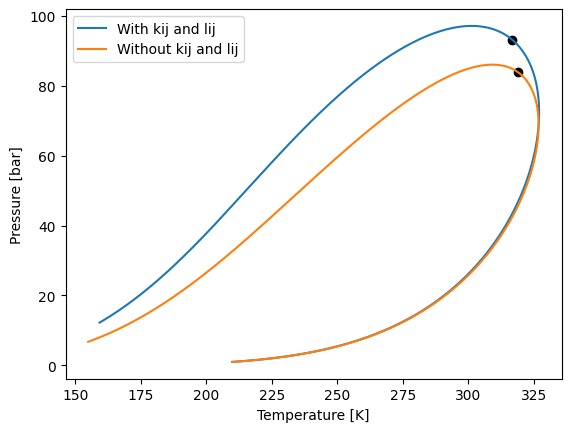

In [2]:
import matplotlib.pyplot as plt

# Composition of the mixture
z = np.array([0.5, 0.5])

# Initial guesses for the envelope (not too important right now)
t0 = 150.0
p0 = 1.0

# Envelope with the model with kij and lij
envelope_kij = model_kij.phase_envelope_pt(z, t0=t0, p0=p0, kind="dew")

# Envelope with the model without kij and lij
envelope = model.phase_envelope_pt(z, t0=t0, p0=p0, max_points=1000, kind="dew")

# Plot
envelope_kij.plot(label="With kij and lij")
envelope.plot(label="Without kij and lij")

plt.legend()
plt.xlabel("Temperature [K]")
plt.ylabel("Pressure [bar]");

The QMR mix rule can be used with any cubic equation of state that `yaeos`
supports.

## QMRTD: QMR with temperature dependence of $k_{ij}$
It is possible also to give some dependence of temperature to the $k_{ij}$
values, corresponding to the equations:

$$
nB = \sum_i \sum_j n_i n_j \frac{b_i + b_j}{2} (1 - l_{ij})
$$

$$
D = \sum_i \sum_j n_i n_j a_{ij}
$$

With:

$$
a_{ij} = \sqrt{a_i \, a_j} (1 - k_{i,j})
$$


$$
    k_{ij}(T) = k_{ij}^{\infty} + k_{ij}^{0} \exp{\left(-T/T^{ref}\right)}
$$

In [3]:
import yaeos


tcs = np.array([190.6, 369.8])  # critical temperatures [K]
pcs = np.array([45.99, 42.48])  # critical pressures [bar]
w = np.array([0.0115, 0.0866])  # acentric factors [-]

# Binary interaction parameters:
## Strong repulsions at low temperatures
kij_0 = [[0.0, 0.23], [0.23, 0.0]]

## "attraction" at high temperatures
kij_inf = [[0.0, -0.01], [-0.01, 0.0]]

Tref = [[0.0, 350], [350, 0.0]]

lij = [[0.0, 0.01], [0.01, 0.0]]

# Quadratic mixing rule instance
mixrule = yaeos.QMRTD(kij_0, kij_inf, Tref, lij)

model_kij_tdep = yaeos.PengRobinson76(
    critical_temperatures=tcs,
    critical_pressures=pcs,
    acentric_factors=w,
    mixrule=mixrule, # <- here comes the mixing rule
)

model_kij_tdep.pressure([0.5, 0.5], 2, 200)

6.959049536037986

Text(0, 0.5, 'Pressure [bar]')

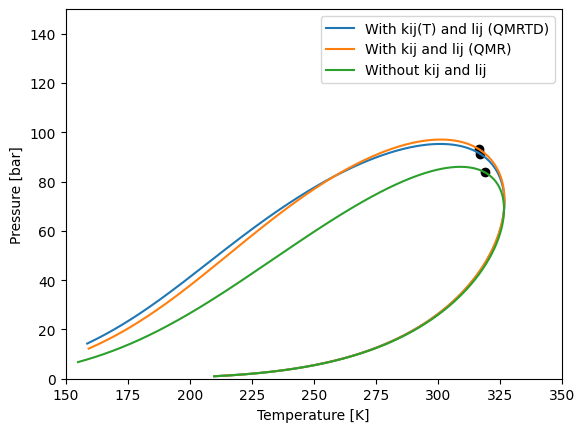

In [4]:
z = np.array([0.5, 0.5])
t0 = 150.0
p0 = 1.0

# Envelope with the model with kij and lij
envelope_kij_tdep = model_kij_tdep.phase_envelope_pt(z, kind="dew", t0=t0, p0=p0)

# Plot
envelope_kij_tdep.plot(label="With kij(T) and lij (QMRTD)")
envelope_kij.plot(label="With kij and lij (QMR)")
envelope.plot(label="Without kij and lij")

plt.legend()
plt.xlim(150, 350)
plt.ylim(0, 150)
plt.xlabel("Temperature [K]")
plt.ylabel("Pressure [bar]")

## Huron-Vidal mixing rule

The Huron-Vidal mixing rule allows linking a Cubic Equation of State with an
Excess Gibbs model, this can be helpful to predict behaviour of systems with
high asymmetry in polarity.

In [5]:
import yaeos

import numpy as np


tcs = np.array([190.6, 369.8])  # critical temperatures [K]
pcs = np.array([45.99, 42.48])  # critical pressures [bar]
w = np.array([0.0115, 0.0866])  # acentric factors [-]

# binary interaction parameters for NRTL model
aij = np.array([[0.0, -1.2], [0.5, 0.0]])

bij = np.array([[0.0, 100.0], [-100.0, 0.0]])

cij = np.array([[0.0, 0.3], [0.3, 0.0]])

nrtl = yaeos.NRTL(aij, bij, cij)

mixing_rule = yaeos.HV(ge=nrtl)

# Set a model with the MHV with parameters
model_hv_nrtl = yaeos.PengRobinson76(
    critical_temperatures=tcs,
    critical_pressures=pcs,
    acentric_factors=w,
    mixrule=mixing_rule,
)

## Modified Huron-Vidal mixing rule (MHV)

The other mixing rule that `yaeos` supports is the MHV mixing rule. To use it
we need to instantiate an Excess Gibbs free energy model and pass it to the
MHV mixing rule. Any of the supported Excess Gibbs models could be supplied.

$$
nB = \sum_i \sum_j n_i n_j \frac{b_i + b_j}{2} (1 - l_{ij})
$$

$$
\frac{D}{RTB} = \sum_i n_i \frac{a_i(T)}{b_i} + \frac{1}{q}
\left(\frac{G^E(n, T)}{RT} + \sum_i n_i \ln \frac{B}{nb_i} \right)
$$

In [6]:
import yaeos

import numpy as np


# binary interaction parameters for NRTL model
aij = np.array([[0.0, -1.2], [0.5, 0.0]])

bij = np.array([[0.0, 100.0], [-100.0, 0.0]])

cij = np.array([[0.0, 0.3], [0.3, 0.0]])

# Set an NRTl model
nrtl = yaeos.NRTL(aij, bij, cij)

# Mixing rule instance
mixing_rule = yaeos.MHV(ge=nrtl, q=-0.53)

# Set a model with the MHV with parameters
model_mhv_nrtl = yaeos.PengRobinson76(
    critical_temperatures=tcs,
    critical_pressures=pcs,
    acentric_factors=w,
    mixrule=mixing_rule, # <- mixing rule
)

Let's make first an envelope to see the difference and then explain what is
happening.

(0.0, 150.0)

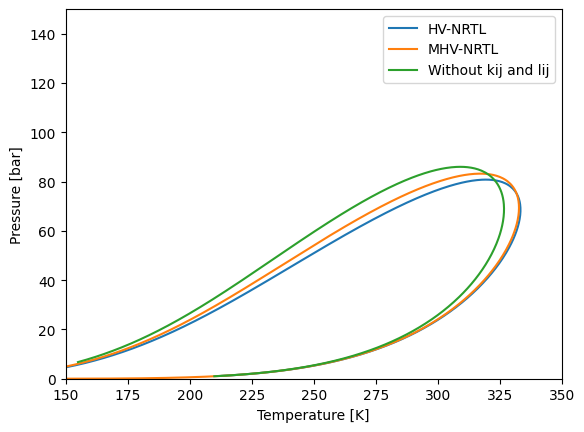

In [7]:
import matplotlib.pyplot as plt


z = np.array([0.5, 0.5])
t0 = 150.0
p0 = 1.0

# Envelope with the model with HV and NRTL
envelope_mhv_nrtl = model_mhv_nrtl.phase_envelope_pt(
    z, t0=t0, p0=p0, max_points=5000
)

# Envelope with the model with MHV and NRTL
envelope_hv_nrtl = model_hv_nrtl.phase_envelope_pt(
    z, t0=t0, p0=p0, max_points=1000
)

# Plot
plt.plot(envelope_hv_nrtl["T"], envelope_hv_nrtl["P"], label="HV-NRTL")
plt.plot(envelope_mhv_nrtl["T"], envelope_mhv_nrtl["P"], label="MHV-NRTL")
plt.plot(envelope["T"], envelope["P"], label="Without kij and lij")

plt.legend()
plt.xlabel("Temperature [K]")
plt.ylabel("Pressure [bar]")
plt.xlim(150, 350)
plt.ylim(0, 150)

We have instantiated a `NRTL` model with some interaction parameters and then
instantiated a `MHV` mixing rule with the `NRTL` model. The `q` value of the
`MHV` mixing rule is taken from bibliography. The value to use are:

- q = -0.594 for Soave-Redlich-Kwong
- q = -0.53 for Peng-Robinson
- q = -0.85 for Van der Waals

## Huron-Vidal Coupled with NRTL Mixing Rule

Huron and Vidal presented their mixing rule with a modified $NRTL$ model. 
This model includes the covolume parameter $b$ from the cubic EoS. This 
modification has the characteristic that it can be simplified and use the
classic QMR mixing rules for specific binaries in the mixture.

First we will define a model that uses the $QMR$ mixing rule

In [8]:
import yaeos

import numpy as np


# Methane, butane, CO2
Tc =  [190.564, 425.12, 304.21]
Pc =  [45.99, 37.96, 73.83]
w =  [0.0115478, 0.200164, 0.223621]

# binary interaction parameters
kij = np.array(
    [[0.0, 0.0, 0.1], 
     [0.0, 0.0, 0.0],
     [0.1, 0.0, 0.0]
     ])

# Set QMR
mixing_rule = yaeos.QMR(kij=kij, lij=0*kij)

# Set a model with the QMR with parameters
model_kij = yaeos.PengRobinson76(
    critical_temperatures=Tc,
    critical_pressures=Pc,
    acentric_factors=w,
    mixrule=mixing_rule, # <- mixing rule
)

Now we will define a model using the $NRTLHV$ mixing rule

In [9]:
alpha = [
    [0.0, 0.1, 0.2],
    [0.3, 0.0, 0.5],
    [0.1, 0.1, 0.0]
]

gji = [
    [0.0, 22., 50.],
    [20.0, 0.0, 10.],
    [0.1, 50.0, 0.0]
]

# Where to use kij values
use_kij = np.full((3, 3), False)

# While we must provide a kij matrix, it will not be used since all the use_kij
# matrix is set to False
mixrule = yaeos.HVNRTL(alpha=alpha, gji=gji, use_kij=use_kij, kij=kij)

model_hvnrtl = yaeos.PengRobinson76(
    critical_temperatures=Tc,
    critical_pressures=Pc,
    acentric_factors=w,
    mixrule=mixrule, # <- mixing rule
)

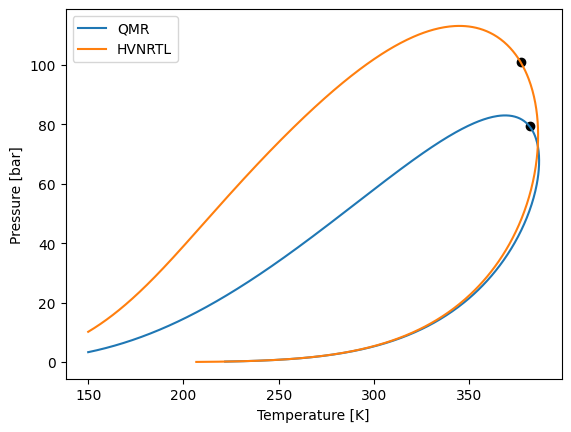

In [10]:
z = [0.2, 0.5, 0.3]

model_kij.phase_envelope_pt(z).plot(label="QMR")
model_hvnrtl.phase_envelope_pt(z).plot(label="HVNRTL")

plt.legend()


Now let's modify the `use_kij` matrix, to use the kij values between methane and
butane.

In [11]:
use_kij[0, 1] = True
use_kij[1, 0] = True

mixrule = yaeos.HVNRTL(alpha=alpha, gji=gji, use_kij=use_kij, kij=kij)

model_hvnrtl_2 = yaeos.PengRobinson76(
    critical_temperatures=Tc,
    critical_pressures=Pc,
    acentric_factors=w,
    mixrule=mixrule,
)

When we plot the phase envelopes we can se how using the $k_{ij}$ values for
methane-butane the phase diagram become more similar to the one with the classic
$QMR$

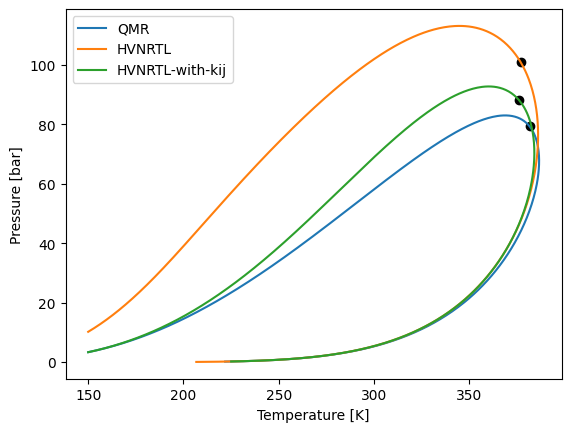

In [12]:
model_kij.phase_envelope_pt(z).plot(label="QMR")
model_hvnrtl.phase_envelope_pt(z).plot(label="HVNRTL")
model_hvnrtl_2.phase_envelope_pt(z).plot(label="HVNRTL-with-kij")

plt.legend()
plt.show()